In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])

# Linear Regression by Gradient Descent with `jax` Auto-differentiation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1l0rNIYaHt9mQQ4rDQXattrT8d3THh9IX?usp=sharing)

This is a simple demonstration of how we might use `jax`'s automatic differentation capabilities. We'll create a simple linear regression problem, but rather than just rely on its well-known analytical solution, we'll also solve it from the vantage point of a numerical optimization problem, using a very basic gradient descent algorithm.

This example is inspired by Jeremy Howard's demo of SGD using the fast.ai library in earlier versions of his fast.ai deep learning online course.

## Generating random data

We'll start by generating some random data in the $x$-$y$ plane. Doing so will immediately highlight some of the quirks to know about when using `jax`.

We start with our standard imports.

In [2]:
import numpy as np
import jax.numpy as jnp

You'll notice that one of our first steps is to import the `jax.numpy` package with the alias `jnp`. This is a re-implementation of much of the core `numpy` library within `jax`. It provides a familiar set of tools which are natively supported by the advanced functionalities of the `jax` library.

Let's generate a random set of points:

In [3]:
from jax import random

def make_key():
    """ Helper function to generate a key for jax's parallel PRNG 
    using standard numpy random functions. 

    """
    seed = np.random.randint(2**16 - 1)
    return random.PRNGKey(seed)

n = 100
rands = random.uniform(make_key(), shape=(n, ), minval=-1, maxval=1)

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Here, we've generated a 100-element vector of random values from the interval $[-1, 1]$. You may notice that when we called the random number generator we passed it a specially initialized `random.PRNGKey` object. This process is a bit different than what we might do in vanilla NumPy; for more details there is a [great write-up](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#%F0%9F%94%AA-Random-Numbers) in the `jax` documentation.

In [4]:
from jax.ops import index, index_update

_ = np.ones((n, 2))
_[:, 0] = rands

x = jnp.ones((n, 2))
x = index_update(x, index[:, 0], rands)

Another new thing; the first two lines here show a typical NumPy-esque approach to creating a rank-2 matrix containing our random values. But with `jax`, things are a little bit different. This is because `jax` relies on a pure, functional representation of your numerical code. Rather than mutate arrays in-place, with `jax` we have to use specally functional update functions, such as `index_update` (for in-place overwrites of array values) and `index_add` (for in-place addition of an array or scalar to values in another array).

For our problem, we will generate some data using a very simple linear model of the form 

$$y = \mathbf{X}\beta + \epsilon$$

where $\beta$ is comprised of $\beta_0$ (a "bias" or offset) and $\beta_1$ (a slope relating $x$ and $y$). Here, we assume our error term $\epsilon$ is uncorrelated noise modeled with a simple normal distribution, $\mathcal{N}(0, 1)$.

In [5]:
# Fix our "true" slope and bias terms
slope, bias = (3., 2.)
beta_true = jnp.array((slope, bias))

errs = random.normal(make_key(), shape=(n, ))

With this setup, generating our sample data is just normal `numpy`-esque code!

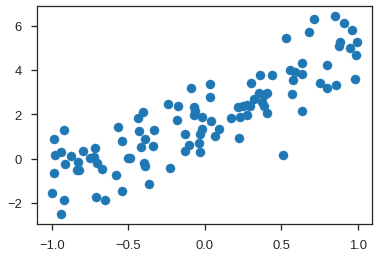

In [6]:
y = (x @ beta_true) + errs

plt.scatter(x[:, 0], y);

## Analytical model fitting

We seek to find parameters $\beta_i$ such that we minimize some cost (or "loss") function associated with a model predicting the relationship between $x$ and $y$. Generally speaking, this problem is simple enough that for certain cost functions, we can analytically derive a solution.

As an example, let $L(\beta) = ||\mathbf{X}\beta - \mathbf{Y}||^2$ be our cost function. This function is convex, and we can optimize it (find a minimum) using simple calculus. We solve for the gradient of $L$ with respect to $\beta$,

$$\frac{\partial L(\beta)}{\partial \beta} = -2\mathbf{Y}^T\mathbf{X} + 2\beta^T\mathbf{X}^T\mathbf{X}$$

Setting this equal to $0$ and solving yields

$$\beta = \left(\mathbf{X}^T\mathbf{X}\right)^{-1}\mathbf{X}^T\mathbf{Y}$$

Since `jax` implements a portion of the linear algebra libraries exposed via `numpy`, it is very simple to compute this analytical solution:

In [7]:
beta_ols = jnp.linalg.inv(x.T @ x) @ (x.T @ y)
print(beta_ols)

[2.9323535 1.8708069]


It's not perfect given the noise in our model, but when we plot the fitted line all looks well:

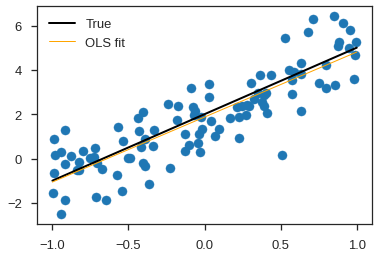

In [8]:
plt.scatter(x[:, 0], y)

xs = np.linspace(-1, 1)
xs = np.stack([xs, np.ones_like(xs)], axis=1)
ys_true = xs@beta_true
ys_fit = xs@beta_ols
plt.plot(xs[:, 0], ys_true, color='k', lw=2, label="True")
plt.plot(xs[:, 0], ys_fit, color='orange', lw=1, label='OLS fit')
plt.legend();

## An alternative model fitting - Gradient Descent

A reasonable question is what would we do if we had a similar modeling problem for which we couldn't write an analytical solution? In that case, there are other approaches we can use to optimize our model parameters.

One strategy which works well for convex functions is to use gradient descent. 
**Gradient descent** is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.

Here, we'll minimize an error metric which corresponds to the same metric we used in the least-squares optimization above, mean squared error:


$$\mathrm{MSE} = \frac{1}{n}\sum\limits^n (\hat{y_i} - y_i)^2$$

In [9]:
def mse(y_hat, y):
    return jnp.power(y_hat - y, 2).mean()

There is nothing special about this calculation - we're writing standard `numpy`-esque code, which we can then easily apply to test data.

In [10]:
a_test = jnp.array([-1., 1.])
print(mse(x@a_test, y))

7.0792613


The "loss function" we wish to optimize will be the MSE computed for a given draw of parameters $\beta_i$. As in most optimization problems, we need to understand the gradient of the loss function with respect to these parameters ($\frac{\partial L(\mathbf{\beta})}{\partial \mathbf{\beta}}$ from before).

We have a few options for computing this gradient. In some trivial cases (as here), we can compute the derivatives analytically. If that is cumbersome, then we can always turn to numerical analysis and estimate the gradients using simple finite differences or other techniques. But what happens if there are a very large number of parameters in our model, or our error metric is very complex? In such a case it may be impractical to write efficient code for the gradient.

Enter [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), which is a technique to programatically "construct" derivatives of functions encoded as computer programs. `jax` provides out-of-the-box capabilities to perform this sorts of computations.

In [11]:
from jax import grad

def predict(beta, x):
    return x@beta

def loss_fun(beta, x, y=y):
    preds = predict(beta, x)
    return mse(preds, y)

grad_loss_fun = grad(loss_fun, argnums=0)

Think about what we've done here. We've defined a simple function, `predict()`, that executes our model given a set of parameters (`beta`). We've then written a function, `loss_fun()`, which runs the prediction and computes an error score relative to some ground truth. Then - magic! With an invocation of `jax.grad`, we have _differentiated_ the composition of functions, with respect to the parameter vector `beta`. The resulting function lets us compute the gradient of `loss_fun()` with respect to parameters at any set of inputs:

In [12]:
print(a_test, grad_loss_fun(a_test, x))

[-1.  1.] [-2.7168233 -1.5580882]


Recall that our goal here is to _optimize_ the loss function with respect to our parameters. Intuitively, we can do this by "following the gradient". Just as you would do if you were hiking and wanted to get to the river in the valley below, one strategy might be to find the steepest direction you could move and take a few small steps in that direction; if you're deliberate about your step size, and repeat the process by finding a new steepest direction every few steps, this algorithm is more-or-less guaranteed to get you down to the river.

The same general intuition applies when optimizing a function. We ultimately seek a set of parameters that minimizes the loss, so by finding the gradient of the loss with respect to those parameters and taking a few small "steps" in that direction, we can usually numerically approximate that set of parameters we're seeking.

More specifically, we will compute a sequences of parameters $\beta_n$ such that

$$\beta_{n+1} = \beta_n - \gamma \frac{\partial L (\beta)}{\partial \beta}$$

The differential is our gradient, and $\gamma$ is the size of the step we take from our current position, $\beta_n$. We typically choose a very small $\gamma \in \mathbb{R}$. In the parlance of numerical methods, this is our "learning rate". In more sophisticated applications, this rate may change over time as we get closer to what we hope is the "right" answer. Ultimately, we _hope_ that by iterating this sequence over time, the rate of change between successive terms will become very small.

In [13]:
def gradient_descent_step(beta, lr=1e-1, x=x):
    beta_grad = grad_loss_fun(beta, x)
    beta = index_update(beta, index[:], beta - lr*beta_grad)
    return beta

Let's see this algorithm in action:

In [14]:
beta_gd = jnp.array([-1., 1.])
γ = 5e-2

for t in range(200):

    if (t % 10) == 0:
        print(t, beta_gd)

    new_beta = gradient_descent_step(beta_gd)

    rel_err = np.sqrt(np.mean((beta_gd - new_beta)**2))
    if rel_err < 1e-3:
        print(f"Converged -> relative error = {rel_err:g}")
        break

    beta_gd = new_beta

0 [-1.  1.]
10 [1.0183814 1.723933 ]
20 [2.0045197 1.8291312]
30 [2.4829679 1.8537816]
40 [2.7147415 1.862901 ]
50 [2.8269806 1.867015 ]
60 [2.88133   1.8689747]
70 [2.9076474 1.8699201]
Converged -> relative error = 0.000983836


And our line-of-best-fit based on our optimized parameters vector:

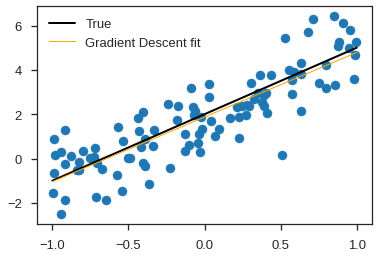

In [15]:
plt.scatter(x[:, 0], y)

xs = np.linspace(-1, 1)
xs = np.stack([xs, np.ones_like(xs)], axis=1)
ys_true = xs@beta_true
ys_fit = xs@beta_gd
plt.plot(xs[:, 0], ys_true, color='k', lw=2, label="True")
plt.plot(xs[:, 0], ys_fit, color='orange', lw=1, label='Gradient Descent fit')
plt.legend();

## Animated Example

Just for fun, we can plot this optimization as an animation.

In [16]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [17]:
a = jnp.array([-1., 1.])
lr = 5e-2

fig = plt.figure()
plt.scatter(x[:,0], y, c='orange')
y_hat = x@a
line, = plt.plot(x[:,0], y_hat)
_ = plt.plot(x[:, 0], x@beta_true, color='k', lw=2)
plt.close()

def update():
    """ Tweak of algo using globals for making animation easier. """
    global a
    a_grad = grad_loss_fun(a, x)
    a = index_update(a, index[:], a - lr*a_grad)

def animate(i):
    update()
    y_hat = x@a
    line.set_ydata(y_hat)
    return line,

animation.FuncAnimation(fig, animate, np.arange(0, 200), interval=20)